In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc
%store -r Y_relative_footsteps_acc
print(X_relative_footsteps_acc.shape)
print(Y_relative_footsteps_acc.shape)

(21881, 28)
(21881, 8)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RR supports
idxs = np.where(X_relative_footsteps_acc[:, 24] == 0)[0]
X_relative_footsteps_acc_RR_support = X_relative_footsteps_acc[idxs]
Y_relative_footsteps_acc_RR_support = Y_relative_footsteps_acc[idxs]

## Predict RR foot -> x

In [8]:
X_relative_footsteps_acc_RR_support.shape

(11025, 28)

In [9]:
X_relative_footsteps_acc_RR_support[0, :]

array([ 0.        ,  0.        ,  0.        , -0.01667854,  0.02806931,
        0.04898649, -0.00293043,  0.04369139, -0.00966195,  0.22882891,
        0.16832004, -0.40987395,  0.23396882, -0.16832977, -0.40997042,
       -0.24291083,  0.16426133, -0.41338172, -0.24842681, -0.16367363,
       -0.41372354,  0.        ,  1.        ,  1.        ,  0.        ,
        0.1       ,  0.        ,  0.        ])

In [10]:
Y_relative_footsteps_acc_RR_support[0, :]

array([ 0.23372304,  0.17114156,  0.23612243, -0.16703353, -0.24142041,
        0.16586816, -0.24356714, -0.16141067])

### Linear Regression

In [35]:
# Input
X = np.hstack((X_relative_footsteps_acc_RR_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_RR_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_RR_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_RR_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_RR_support[:, 6]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_rr_relative_support_x = LinearRegression()

# Fit the model
model_rr_relative_support_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.6521369440220406
RMSE:  0.01081836124807723
The lowest error is:  2.816383997628069e-06
The highest error is:  0.06851436729654875
The avg. error is:  0.007294539344174607


In [36]:
model_rr_relative_support_x.coef_

array([[-0.04592321,  0.05992726,  0.00444163, -0.05940514, -0.00592916,
        -0.0015923 , -0.26720297, -0.2507139 , -0.09690001, -0.12898225,
        -0.00549156, -0.03475759,  0.75317466, -0.35805392]])

In [37]:
model_rr_relative_support_x.intercept_

array([-0.00632505])

Text(0, 0.5, 'Predictions')

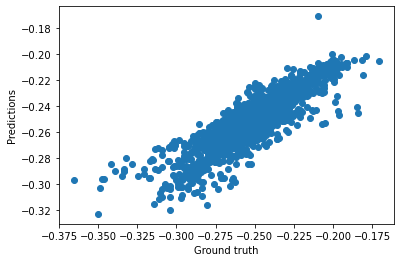

In [38]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [39]:
#%store model_rr_relative_support_x

In [40]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [41]:
# Save model
#joblib.dump(model_rr_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_support_x.sav")

### Predict FL foot -> y

In [91]:
# Input
X = np.hstack((X_relative_footsteps_acc_RR_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_RR_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_RR_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_RR_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_RR_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_RR_support[:, 7]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_rr_relative_support_y = LinearRegression()

# Fit the model
model_rr_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.600567986828904
RMSE:  0.01153417848978527
The lowest error is:  6.147470184847403e-07
The highest error is:  0.08293033671985231
The avg. error is:  0.0077701558787970255


In [92]:
model_rr_relative_support_y.coef_

array([[ 0.0467644 , -0.11682995, -0.03738772, -0.01554283, -0.04175731,
        -0.04767361, -0.41178566, -0.0363657 , -0.0592284 , -0.14906208,
         0.03646865, -0.01642791,  0.06434424,  1.08297395]])

In [93]:
model_rr_relative_support_y.intercept_

array([0.13677799])

Text(0, 0.5, 'Predictions')

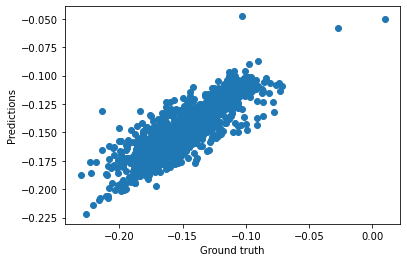

In [94]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [70]:
X_test[0].shape

(14,)

In [36]:
input_ = np.array([[0,0,0,0.1,0,0,0.23194,
    0.173315,
     0.23194,
   -0.173315,
    -0.24786,
    0.173315,
    -0.24786,
   -0.173315]])

In [37]:
input_.shape

(1, 14)

In [38]:
input_

array([[ 0.      ,  0.      ,  0.      ,  0.1     ,  0.      ,  0.      ,
         0.23194 ,  0.173315,  0.23194 , -0.173315, -0.24786 ,  0.173315,
        -0.24786 , -0.173315]])

In [39]:
model_rr_relative_support_y.predict(input_)

array([[-0.17578958]])

In [41]:
model_rr_relative_support_y.coef_.shape

(1, 14)

In [44]:
input_ @ model_rr_relative_support_y.coef_.T + model_rr_relative_support_y.intercept_

array([[-0.17578958]])

In [42]:
#%store model_rr_relative_support_y

In [43]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [44]:
# Save model
#joblib.dump(model_rr_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_rr_relative_support_y.sav")